# Enhance the dataset 
Enhance the dataset to achieve a more realistic data

## *Table of Contents*

1. [Enhance the original Dataset](#1.-Enhance-the-original-Dataset)
    - [1. Enhance the Transaction Table](#1.1-Enhance-Transaction-table)
    - [2. Enhance Store Location in "Stores" Table](#store_table)
    - [3. Enhance Data Complexity for 'Train' Table](#train_table)

2. [Extend "Test" Table for Forecasting](#test_table)



## 1. Enhance the original Dataset

In [9]:
# Import neccessary libraries 
import pandas as pd
import numpy as np 
import seaborn as sns 

import matplotlib.pyplot as plt


### 1.1 Enhance Transaction table

In [2]:
# Import the file 
# train = pd.read_csv("G:/My Drive/Lily Career/Work/Portfolio/Favorita Retails - Sale Forecast/train.csv",delimiter=";")
train_df = pd.read_csv("G:/My Drive/Lily Career/Work/Portfolio/Favorita Retails - Sale Forecast/train_adjusted.csv",delimiter=";")
transactions_df = pd.read_csv("G:/My Drive/Lily Career/Work/Portfolio/Favorita Retails - Sale Forecast/transactions.csv")

train_df['date'] = pd.to_datetime(train_df['date'])
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

In [4]:
# Aggregate sales & promotions at the store level per day
promo_sales = train_df[train_df['onpromotion'] > 0].groupby(['date', 'store_nbr'])['sales'].sum().reset_index(name='sales_promo')
non_promo_sales = train_df[train_df['onpromotion'] == 0].groupby(['date', 'store_nbr'])['sales'].sum().reset_index(name='sales_nonpromo')

# Aggregate the total number of items on promotion per store and date
promo_counts = train_df.groupby(['date', 'store_nbr'])['onpromotion'].sum().reset_index(name='total_onpromotion')

# Merge promo and sales data into transactions_df
transactions_df = transactions_df.merge(promo_counts, on=['date', 'store_nbr'], how='left')
transactions_df = transactions_df.merge(promo_sales, on=['date', 'store_nbr'], how='left')
transactions_df = transactions_df.merge(non_promo_sales, on=['date', 'store_nbr'], how='left')

# Fill missing values (assume 0 if no promo/non-promo sales were recorded)
transactions_df[['total_onpromotion', 'sales_promo', 'sales_nonpromo']] = transactions_df[['total_onpromotion', 'sales_promo', 'sales_nonpromo']].fillna(0)


In [6]:
# Compute a weighted promotion proportion using both number of items promoted and sales
transactions_df['promo_proportion'] = (
    (transactions_df['total_onpromotion'] + transactions_df['sales_promo']) /
    (transactions_df['transactions'] + transactions_df['sales_promo'] + transactions_df['sales_nonpromo'])
).clip(0, 1)  # Ensure proportion is within [0,1]

In [8]:
# Introduce slight random variation (±5%)
np.random.seed(42)
transactions_df['promo_proportion'] *= np.random.uniform(0.95, 1.05, len(transactions_df))

# Clip values to avoid exceeding bounds due to randomness
transactions_df['promo_proportion'] = transactions_df['promo_proportion'].clip(0, 1)

# Compute transactions for promoted and non-promoted sales (ensuring integers)
transactions_df['transactions_promo'] = (transactions_df['transactions'] * transactions_df['promo_proportion']).round().astype(int)
transactions_df['transactions_nonpromo'] = transactions_df['transactions'] - transactions_df['transactions_promo']


In [10]:
# Create separate rows for promoted and non-promoted transactions
promo_rows = transactions_df.copy()
promo_rows['promotion_status'] = True
promo_rows['transactions'] = promo_rows['transactions_promo']

non_promo_rows = transactions_df.copy()
non_promo_rows['promotion_status'] = False
non_promo_rows['transactions'] = non_promo_rows['transactions_nonpromo']

# Combine both datasets
transactions_df_final = pd.concat([promo_rows, non_promo_rows], ignore_index=True)

# Drop unnecessary columns
transactions_df_final = transactions_df_final.drop(columns=['total_onpromotion', 'promo_proportion', 'transactions_promo', 'transactions_nonpromo', 'sales_promo', 'sales_nonpromo'])

# Sort and reset index
transactions_df_final = transactions_df_final.sort_values(by=['date', 'store_nbr']).reset_index(drop=True)

In [15]:
# Adjusted the promo_status column 
transactions_df_final['promo_status']= transactions_df_final['promotion_status'].apply(lambda x: "promotion" if x else "non-promotion")
transactions_df_final = transactions_df_final.drop(columns=['promotion_status'])

In [17]:
transactions_df_final.to_csv('transactions_adjusted.csv',index=False)

<a id="store_table"></a>
### 1.2. Enhance store location in "stores" table
Retrieve the corresponding latitude and longitude and state and city in the table. 

In [19]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# Load the dataset
stores_df = pd.read_csv("G:/My Drive/Lily Career/Work/Portfolio/Favorita Retails - Sale Forecast/cleaned_stores.csv")

# Initialize geolocator
geolocator = Nominatim(user_agent="geo_lookup")

In [20]:
# Function to get latitude and longitude
def get_coordinates(location):
    try:
        loc = geolocator.geocode(location, timeout=10)
        if loc:
            return pd.Series([loc.latitude, loc.longitude])
        else:
            return pd.Series([None, None])
    except GeocoderTimedOut:
        return pd.Series([None, None])

# Create a new column with city and state for lookup
stores_df[['latitude', 'longitude']] = stores_df.apply(lambda row: get_coordinates(f"{row['city']}, {row['state']}, Ecuador"), axis=1)

In [23]:
import requests

# URL of the JSON file
url = "https://cdn.jsdelivr.net/npm/latam-atlas@0.1.0/files/ecuador-tm-50k.json"

# Download and save the file
response = requests.get(url)
if response.status_code == 200:
    with open("ecuador_map.json", "wb") as file:
        file.write(response.content)
    print("Download complete: ecuador_map.json")
else:
    print("Failed to download the file")


Download complete: ecuador_map.json


In [32]:
import json


# Load the JSON file
with open('ecuador_map.json', 'r', encoding='utf-8') as f:
    ecuador_map = json.load(f)

# Extract level 4 (parish) data
parish_mapping = {}
for feature in ecuador_map['objects'][list(ecuador_map['objects'].keys())[0]]['geometries']:
    if 'properties' in feature and 'areacd' in feature['properties'] and 'areanm' in feature['properties']:
        parish_mapping[feature['properties']['areanm'].lower()] = feature['properties']['areacd']


# Normalize area names to lowercase for matching
stores_df['parish_normalized'] = stores_df['city'].str.lower()

# Map areacd to stores_df based on parish name
stores_df['areacd'] = stores_df['parish_normalized'].map(parish_mapping)

# Drop the normalized column
stores_df.drop(columns=['parish_normalized'], inplace=True)


In [ ]:
# Filter cities with null areacd
null_cities = stores_df[stores_df['areacd'].isnull()]['city'].unique()
cities_with_null_areac

array(['Santo Domingo', 'Ibarra', 'Playas', 'Libertad'], dtype=object)

In [37]:
# Predefined dictionary with areacd values for cities in null_cities
areacd_mapping = {
    'Santo Domingo': '2301',
    'Ibarra': '100150',
    'Playas': '092150',
    'Libertad': '110751'
}

# Update the areacd column for cities in null_cities
stores_df.loc[stores_df['city'].isin(cities_with_null_areacd), 'areacd'] = stores_df['city'].map(areacd_mapping)

In [39]:
stores_df.to_csv('stores_adjusted.csv',index=False)

<a id="train_table"></a>
### 1.3 Enhance data complexity for 'train' table

In [ ]:
train['Year'] = train['date'].dt.year
family_list = train['family'].unique().tolist()

# Define the base distribution for key families
base_distribution = {
    "GROCERY I": 0.25,
    "BEVERAGES": 0.15,
    "PRODUCE": 0.12,
    "CLEANING": 0.10,
    "DAIRY": 0.08,
}

# Compute remaining probability and assign to other families
remaining_prob = 1 - sum(base_distribution.values())
remaining_families = [f for f in family_list if f not in base_distribution]

# Function to generate yearly fluctuations
def generate_yearly_distribution(base_distribution, remaining_families, remaining_prob, years):
    np.random.seed(42)
    yearly_distributions = {}

    for year in years:
        # Allow small variations in base categories (±2%)
        fluctuating_base = {
            family: max(0, min(1, prob + np.random.uniform(-0.02, 0.02)))
            for family, prob in base_distribution.items()
        }
        total_fixed = sum(fluctuating_base.values())

        # Generate new probabilities for remaining families
        random_probs = np.random.dirichlet(np.ones(len(remaining_families))) * (1 - total_fixed)

        # Merge into final yearly distribution
        yearly_distributions[year] = fluctuating_base.copy()
        yearly_distributions[year].update(dict(zip(remaining_families, random_probs)))

    return yearly_distributions

# Generate distributions for each year in the dataset
years = sorted(train["Year"].unique())
yearly_distributions = generate_yearly_distribution(base_distribution, remaining_families, remaining_prob, years)

# Function to adjust family distribution per year
def adjust_family_distribution_by_year(df, yearly_distributions):
    np.random.seed(42)
    df_shuffled = df.copy()
    df_shuffled["original_family"] = df_shuffled["family"]

    # Reassign families per year
    new_families = []
    for _, row in df_shuffled.iterrows():
        year = row["Year"]  # Explicitly extract year
        if year in yearly_distributions:
            new_families.append(np.random.choice(
                list(yearly_distributions[year].keys()),
                p=list(yearly_distributions[year].values())
            ))
        else:
            new_families.append(row["family"])  # Fallback to original family if year is missing

    df_shuffled["family"] = new_families
    return df_shuffled.drop(columns=["original_family"])

# Apply the improved adjustment function
train = adjust_family_distribution_by_year(train, yearly_distributions)


<a id="test_table"></a>
## 2. Extend "test" table for forecasting 


In [3]:

from datetime import timedelta

# Load the provided CSV data
df = pd.read_csv("G:/My Drive/Lily Career/Work/Portfolio/Favorita Retails - Sale Forecast/test.csv")

# Convert 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'])




In [14]:
# Identify the unique store_nbr and family combinations
unique_combinations = df[['store_nbr', 'family']].drop_duplicates()

# Determine the initial and target date ranges
start_date = df['date'].min()
end_date_original = df['date'].max()
target_end_date = end_date_original + pd.DateOffset(months=12)

# Create a list of all dates from the day after the last date in the original data
# up to the target end date
all_dates = pd.date_range(start=end_date_original + timedelta(days=1), end=target_end_date)


### 2.1 Analyze the 'onpromotion' distribution 

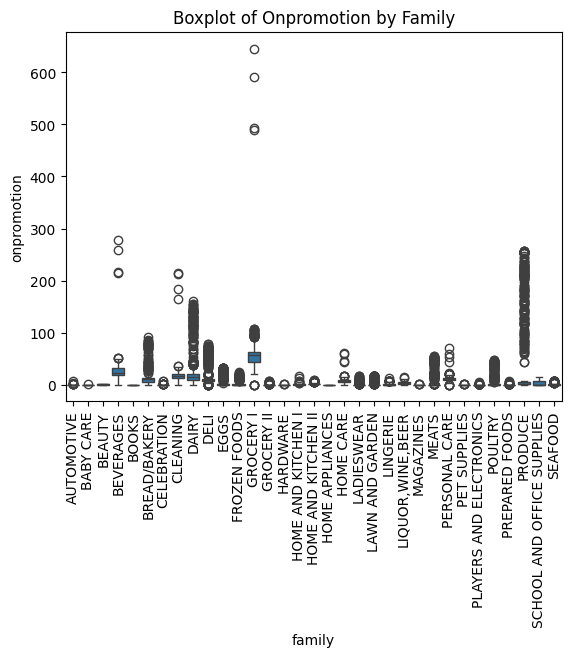

In [15]:

# Draw a boxplot of 
sns.boxplot(data=df, x='family', y='onpromotion')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Boxplot of Onpromotion by Family')
plt.show()

### Mimic the distribution

In [16]:
# Create a dictionary of onprotion distribution 
onpromotion_distributions = {}
for family in df['family'].unique():
    onpromotion_values = df[df['family'] == family]['onpromotion']
    # Get value counts and their probabilities
    value_counts = onpromotion_values.value_counts(normalize=True)
    onpromotion_distributions[family] = {
        'values': value_counts.index.tolist(),
        'probabilities': value_counts.tolist()
    }


In [17]:
# Create an empty list to store the new rows
new_rows = []

# Get the maximum 'id' from the original dataframe to start incrementing from
last_id = df['id'].max()

# Iterate through each new date
for date in all_dates:
    # For each date, iterate through all unique store_nbr and family combinations
    for index, row in unique_combinations.iterrows():
        last_id += 1
        store_nbr = row['store_nbr']
        family = row['family']

        # Generate 'onpromotion' based on the analyzed distribution for the family
        if family in onpromotion_distributions:
            distribution = onpromotion_distributions[family]
            onpromotion = np.random.choice(distribution['values'], p=distribution['probabilities'])
        else:
            # If a new family appears (unlikely with the provided data structure),
            # generate a default random value
            onpromotion = np.random.randint(0, 10)

        new_rows.append({
            'id': last_id,
            'date': date,
            'store_nbr': store_nbr,
            'family': family,
            'onpromotion': onpromotion
        })

# Create a new DataFrame from the generated rows
new_df = pd.DataFrame(new_rows)

# Concatenate the original DataFrame with the new DataFrame
extended_df = pd.concat([df, new_df], ignore_index=True)

# Sort the extended DataFrame by date and then by id to maintain order
extended_df = extended_df.sort_values(by=['date', 'id']).reset_index(drop=True)

# Save the extended DataFrame to a new CSV file
extended_df.to_csv('extended_text.csv', index=False)

print("Extended data with distribution-based 'onpromotion' saved to 'extended_data.csv'")

Extended data with distribution-based 'onpromotion' saved to 'extended_data.csv'
